In [ ]:
import numpy as np
import os
import pickle
from pathlib import Path
import torch
from torch.utils.data import TensorDataset, DataLoader

# MNIST reader
def _read_idx(filename):
    """Read MNIST .idx?-ubyte file (big-endian format)."""
    with open(filename, 'rb') as f:
        magic = f.read(4)
        if len(magic) != 4:
            raise ValueError(f"Invalid file (too short): {filename}")

        zero1, zero2, data_type, dims = magic[0], magic[1], magic[2], magic[3]

        dtype_map = {
            0x08: np.uint8, 0x09: np.int8, 0x0B: np.int16,
            0x0C: np.int32, 0x0D: np.float32, 0x0E: np.float64
        }
        if data_type not in dtype_map:
            raise ValueError(f"Unknown data type 0x{data_type:02x} in {filename}")
        np_dtype = dtype_map[data_type]

        shape = []
        for _ in range(dims):
            dim_bytes = f.read(4)
            if len(dim_bytes) != 4:
                raise ValueError(f"Unexpected end of file in {filename}")
            dim = int.from_bytes(dim_bytes, 'big')
            shape.append(dim)

        data = np.frombuffer(f.read(), dtype=np_dtype)
        return data.reshape(shape)

def load_mnist_raw(mnist_dir):
    p = Path(mnist_dir)
    train_img = _read_idx(p / 'train-images.idx3-ubyte')
    train_lbl = _read_idx(p / 'train-labels.idx1-ubyte')
    test_img  = _read_idx(p / 't10k-images.idx3-ubyte')
    test_lbl  = _read_idx(p / 't10k-labels.idx1-ubyte')
    return (train_img, train_lbl), (test_img, test_lbl)

# CIFAR-10
def _unpickle(file):
    with open(file, 'rb') as fo:
        return pickle.load(fo, encoding='bytes')

def load_cifar10_raw(cifar_dir):
    p = Path(cifar_dir)
    train_imgs, train_lbls = [], []
    for i in range(1, 6):
        batch = _unpickle(p / f'data_batch_{i}')
        train_imgs.append(batch[b'data'])
        train_lbls.extend(batch[b'labels'])
    train_imgs = np.concatenate(train_imgs, axis=0)

    test_batch = _unpickle(p / 'test_batch')
    test_imgs = test_batch[b'data']
    test_lbls = test_batch[b'labels']

    train_imgs = train_imgs.reshape(-1, 3, 32, 32)
    test_imgs  = test_imgs.reshape(-1, 3, 32, 32)

    return (train_imgs, np.array(train_lbls)), (test_imgs, np.array(test_lbls))

# DataLoader wrappers
def make_mnist_loaders(mnist_dir='./MNIST', batch_size=64):
    (X_tr, y_tr), (X_te, y_te) = load_mnist_raw(mnist_dir)

    X_tr = X_tr.astype(np.float32) / 255.0
    X_te = X_te.astype(np.float32) / 255.0
    mean, std = 0.1307, 0.3081
    X_tr = (X_tr - mean) / std
    X_te = (X_te - mean) / std

    X_tr = X_tr[:, None, :, :]      # (N,1,28,28)
    X_te = X_te[:, None, :, :]

    train_ds = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr).long())
    test_ds  = TensorDataset(torch.from_numpy(X_te), torch.from_numpy(y_te).long())

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=1000, shuffle=False)
    return train_loader, test_loader

def make_cifar10_loaders(cifar_dir='./cifar-10-batches-py', batch_size=64):
    (X_tr, y_tr), (X_te, y_te) = load_cifar10_raw(cifar_dir)

    X_tr = X_tr.astype(np.float32) / 255.0
    X_te = X_te.astype(np.float32) / 255.0
    X_tr = (X_tr - 0.5) / 0.5
    X_te = (X_te - 0.5) / 0.5

    train_ds = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr).long())
    test_ds  = TensorDataset(torch.from_numpy(X_te), torch.from_numpy(y_te).long())

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=1000, shuffle=False)
    return train_loader, test_loader

In [ ]:
# loading the data
train_loader_mnist, val_loader_mnist = make_mnist_loaders('./MNIST')
train_loader_cifar, val_loader_cifar = make_cifar10_loaders('./cifar-10-batches-py')

print(f"MNIST  train batches: {len(train_loader_mnist)}")
print(f"CIFAR-10 train batches: {len(train_loader_cifar)}")

/tmp/ipython-input-2774000671.py:81: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  train_ds = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr).long())


MNIST  train batches: 938
CIFAR-10 train batches: 782


In [ ]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os

# settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

EPOCHS = 10
PLOT_DIR = './plots'
os.makedirs(PLOT_DIR, exist_ok=True)

# activation dict
activations = {
    'sigmoid': nn.Sigmoid(),
    'tanh'   : nn.Tanh(),
    'relu'   : nn.ReLU(),
    'elu'    : nn.ELU(),
    'selu'   : nn.SELU()
}

# CNN definitions
class MNIST_CNN(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.MaxPool2d(2)
        self.fc1   = nn.Linear(64*7*7, 128)
        self.fc2   = nn.Linear(128, 10)
        self.act   = activation
    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = self.act(self.fc1(x))
        return self.fc2(x)

class CIFAR_CNN(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool  = nn.MaxPool2d(2)
        self.fc1   = nn.Linear(128*4*4, 512)
        self.fc2   = nn.Linear(512, 10)
        self.act   = activation
    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = self.pool(self.act(self.conv3(x)))
        x = x.view(-1, 128*4*4)
        x = self.act(self.fc1(x))
        return self.fc2(x)

# training loop
def train_model(model, train_loader, val_loader, dataset_name, act_name):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # SELU needs special init
    if act_name == 'selu':
        for m in model.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.normal_(m.weight, mean=0, std=np.sqrt(1/m.weight.numel()))
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    t_loss, v_loss, t_acc, v_acc = [], [], [], []

    for epoch in range(EPOCHS):
        # train
        model.train()
        tr_l, tr_c = 0, 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            tr_l += loss.item()
            tr_c += (out.argmax(1) == y).sum().item()
        t_loss.append(tr_l / len(train_loader))
        t_acc.append(tr_c / len(train_loader.dataset))

        # validate
        model.eval()
        val_l, val_c = 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                out = model(X)
                val_l += criterion(out, y).item()
                val_c += (out.argmax(1) == y).sum().item()
        v_loss.append(val_l / len(val_loader))
        v_acc.append(val_c / len(val_loader.dataset))

        print(f"{dataset_name} [{act_name.upper()}] Epoch {epoch+1}/{EPOCHS} | "
              f"TrainLoss {t_loss[-1]:.4f} ValLoss {v_loss[-1]:.4f} | "
              f"TrainAcc {t_acc[-1]:.4f} ValAcc {v_acc[-1]:.4f}")

    return t_loss, v_loss, t_acc, v_acc

# plotting & saving
def plot_and_save(act, ds, tl, vl, ta, va):
    epochs = range(1, len(tl)+1)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, tl, label='Train loss', marker='o')
    plt.plot(epochs, vl, label='Val loss',   marker='s')
    plt.title(f'{act.upper()} – {ds} loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid()

    plt.subplot(1,2,2)
    plt.plot(epochs, ta, label='Train acc', marker='o')
    plt.plot(epochs, va, label='Val acc',   marker='s')
    plt.title(f'{act.upper()} – {ds} accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Acc'); plt.legend(); plt.grid()

    plt.tight_layout()
    fname = f"{PLOT_DIR}/{ds}_{act}_curves.png"
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved → {fname}\n")

Using device: cuda



=== MNIST EXPERIMENTS ===


--- SIGMOID ---
MNIST [SIGMOID] Epoch 1/10 | TrainLoss 0.6712 ValLoss 0.1844 | TrainAcc 0.7946 ValAcc 0.9466
MNIST [SIGMOID] Epoch 2/10 | TrainLoss 0.1435 ValLoss 0.0923 | TrainAcc 0.9580 ValAcc 0.9738
MNIST [SIGMOID] Epoch 3/10 | TrainLoss 0.0855 ValLoss 0.0685 | TrainAcc 0.9750 ValAcc 0.9790
MNIST [SIGMOID] Epoch 4/10 | TrainLoss 0.0629 ValLoss 0.0529 | TrainAcc 0.9807 ValAcc 0.9835
MNIST [SIGMOID] Epoch 5/10 | TrainLoss 0.0487 ValLoss 0.0460 | TrainAcc 0.9850 ValAcc 0.9854
MNIST [SIGMOID] Epoch 6/10 | TrainLoss 0.0392 ValLoss 0.0425 | TrainAcc 0.9881 ValAcc 0.9858
MNIST [SIGMOID] Epoch 7/10 | TrainLoss 0.0320 ValLoss 0.0397 | TrainAcc 0.9903 ValAcc 0.9874
MNIST [SIGMOID] Epoch 8/10 | TrainLoss 0.0260 ValLoss 0.0429 | TrainAcc 0.9925 ValAcc 0.9854
MNIST [SIGMOID] Epoch 9/10 | TrainLoss 0.0207 ValLoss 0.0331 | TrainAcc 0.9942 ValAcc 0.9882
MNIST [SIGMOID] Epoch 10/10 | TrainLoss 0.0166 ValLoss 0.0351 | TrainAcc 0.9956 ValAcc 0.9879


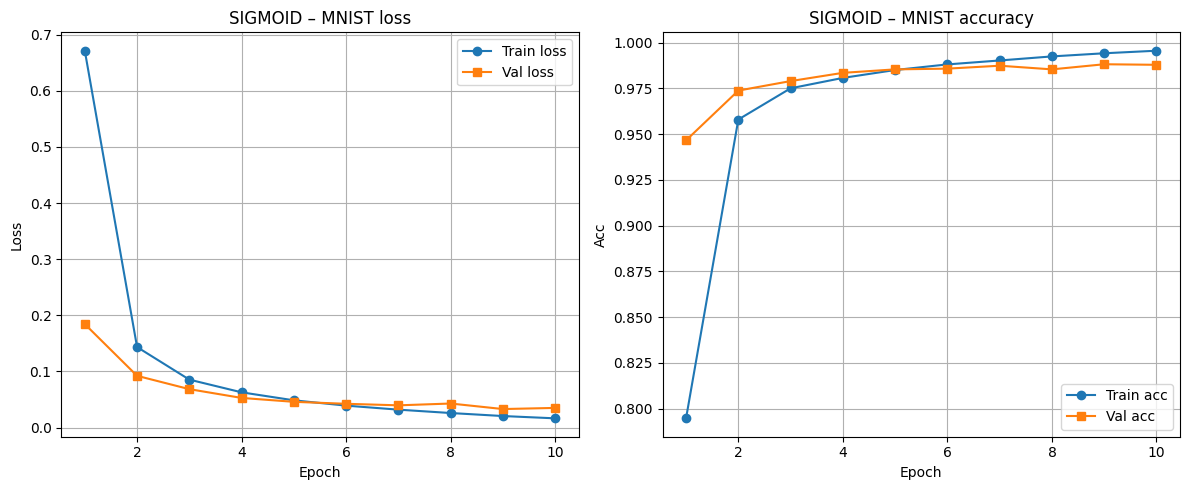

Saved → ./plots/MNIST_sigmoid_curves.png


--- TANH ---
MNIST [TANH] Epoch 1/10 | TrainLoss 0.1401 ValLoss 0.0424 | TrainAcc 0.9594 ValAcc 0.9871
MNIST [TANH] Epoch 2/10 | TrainLoss 0.0428 ValLoss 0.0369 | TrainAcc 0.9875 ValAcc 0.9870
MNIST [TANH] Epoch 3/10 | TrainLoss 0.0291 ValLoss 0.0387 | TrainAcc 0.9913 ValAcc 0.9869
MNIST [TANH] Epoch 4/10 | TrainLoss 0.0220 ValLoss 0.0350 | TrainAcc 0.9935 ValAcc 0.9885
MNIST [TANH] Epoch 5/10 | TrainLoss 0.0157 ValLoss 0.0383 | TrainAcc 0.9953 ValAcc 0.9882
MNIST [TANH] Epoch 6/10 | TrainLoss 0.0147 ValLoss 0.0337 | TrainAcc 0.9954 ValAcc 0.9893
MNIST [TANH] Epoch 7/10 | TrainLoss 0.0121 ValLoss 0.0345 | TrainAcc 0.9964 ValAcc 0.9887
MNIST [TANH] Epoch 8/10 | TrainLoss 0.0093 ValLoss 0.0340 | TrainAcc 0.9973 ValAcc 0.9895
MNIST [TANH] Epoch 9/10 | TrainLoss 0.0095 ValLoss 0.0369 | TrainAcc 0.9970 ValAcc 0.9895
MNIST [TANH] Epoch 10/10 | TrainLoss 0.0086 ValLoss 0.0447 | TrainAcc 0.9972 ValAcc 0.9877


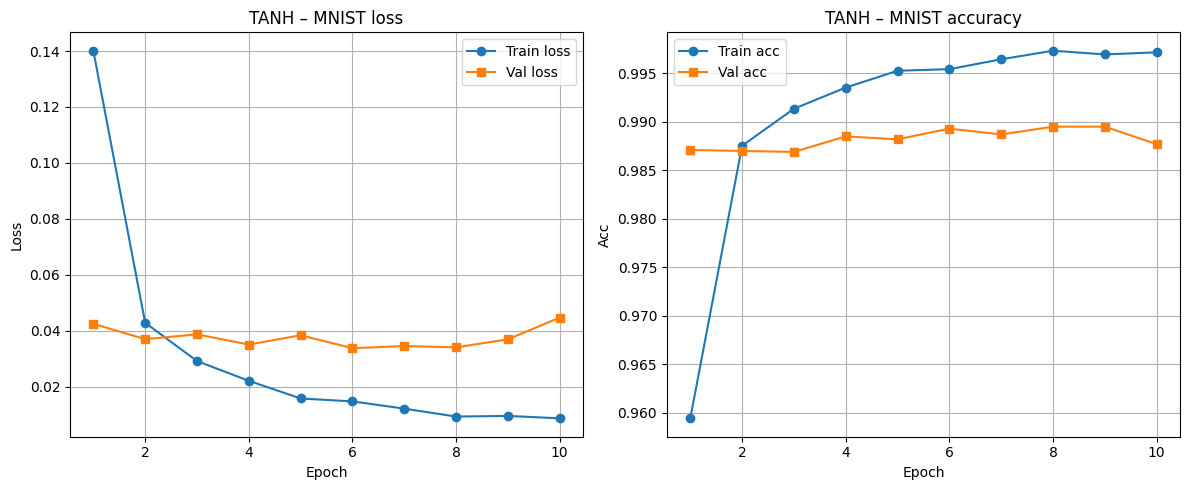

Saved → ./plots/MNIST_tanh_curves.png


--- RELU ---
MNIST [RELU] Epoch 1/10 | TrainLoss 0.1294 ValLoss 0.0402 | TrainAcc 0.9609 ValAcc 0.9870
MNIST [RELU] Epoch 2/10 | TrainLoss 0.0414 ValLoss 0.0288 | TrainAcc 0.9873 ValAcc 0.9896
MNIST [RELU] Epoch 3/10 | TrainLoss 0.0290 ValLoss 0.0339 | TrainAcc 0.9908 ValAcc 0.9893
MNIST [RELU] Epoch 4/10 | TrainLoss 0.0210 ValLoss 0.0356 | TrainAcc 0.9935 ValAcc 0.9882
MNIST [RELU] Epoch 5/10 | TrainLoss 0.0146 ValLoss 0.0306 | TrainAcc 0.9951 ValAcc 0.9914
MNIST [RELU] Epoch 6/10 | TrainLoss 0.0133 ValLoss 0.0297 | TrainAcc 0.9958 ValAcc 0.9919
MNIST [RELU] Epoch 7/10 | TrainLoss 0.0105 ValLoss 0.0308 | TrainAcc 0.9965 ValAcc 0.9908
MNIST [RELU] Epoch 8/10 | TrainLoss 0.0099 ValLoss 0.0249 | TrainAcc 0.9966 ValAcc 0.9940
MNIST [RELU] Epoch 9/10 | TrainLoss 0.0068 ValLoss 0.0337 | TrainAcc 0.9979 ValAcc 0.9909
MNIST [RELU] Epoch 10/10 | TrainLoss 0.0067 ValLoss 0.0373 | TrainAcc 0.9977 ValAcc 0.9911


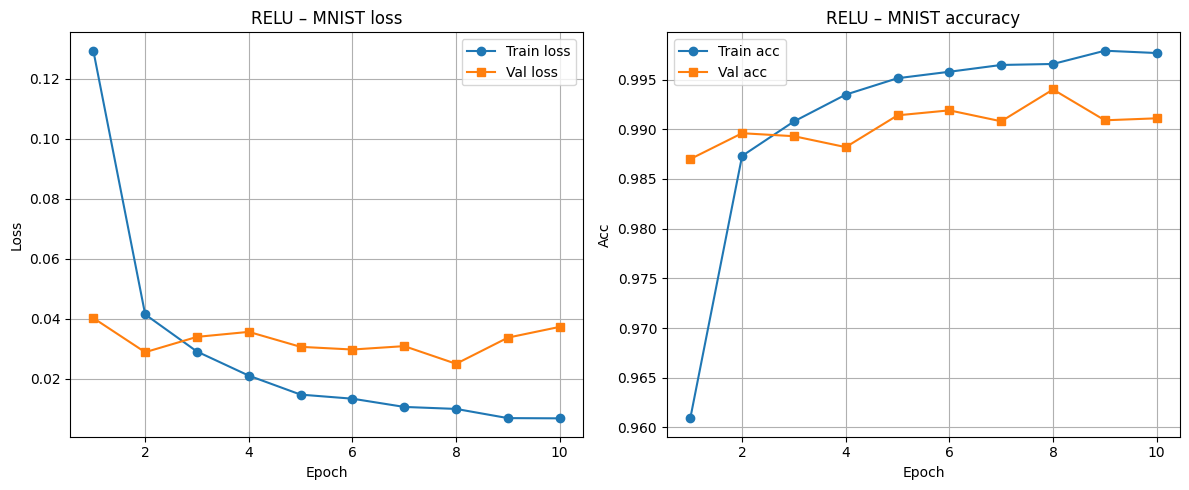

Saved → ./plots/MNIST_relu_curves.png


--- ELU ---
MNIST [ELU] Epoch 1/10 | TrainLoss 0.1135 ValLoss 0.0366 | TrainAcc 0.9641 ValAcc 0.9885
MNIST [ELU] Epoch 2/10 | TrainLoss 0.0388 ValLoss 0.0432 | TrainAcc 0.9874 ValAcc 0.9868
MNIST [ELU] Epoch 3/10 | TrainLoss 0.0264 ValLoss 0.0395 | TrainAcc 0.9911 ValAcc 0.9890
MNIST [ELU] Epoch 4/10 | TrainLoss 0.0212 ValLoss 0.0427 | TrainAcc 0.9928 ValAcc 0.9887
MNIST [ELU] Epoch 5/10 | TrainLoss 0.0167 ValLoss 0.0350 | TrainAcc 0.9946 ValAcc 0.9905
MNIST [ELU] Epoch 6/10 | TrainLoss 0.0123 ValLoss 0.0487 | TrainAcc 0.9959 ValAcc 0.9887
MNIST [ELU] Epoch 7/10 | TrainLoss 0.0131 ValLoss 0.0556 | TrainAcc 0.9958 ValAcc 0.9885
MNIST [ELU] Epoch 8/10 | TrainLoss 0.0123 ValLoss 0.0486 | TrainAcc 0.9962 ValAcc 0.9903
MNIST [ELU] Epoch 9/10 | TrainLoss 0.0085 ValLoss 0.0590 | TrainAcc 0.9970 ValAcc 0.9887
MNIST [ELU] Epoch 10/10 | TrainLoss 0.0119 ValLoss 0.0508 | TrainAcc 0.9964 ValAcc 0.9898


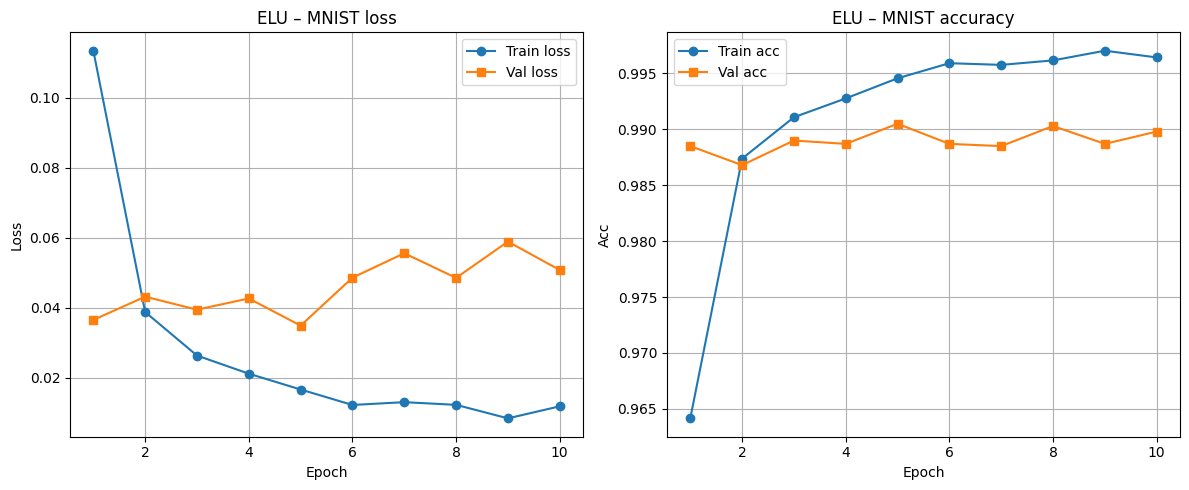

Saved → ./plots/MNIST_elu_curves.png


--- SELU ---
MNIST [SELU] Epoch 1/10 | TrainLoss 0.1452 ValLoss 0.0461 | TrainAcc 0.9546 ValAcc 0.9842
MNIST [SELU] Epoch 2/10 | TrainLoss 0.0450 ValLoss 0.0417 | TrainAcc 0.9864 ValAcc 0.9857
MNIST [SELU] Epoch 3/10 | TrainLoss 0.0318 ValLoss 0.0367 | TrainAcc 0.9897 ValAcc 0.9880
MNIST [SELU] Epoch 4/10 | TrainLoss 0.0219 ValLoss 0.0455 | TrainAcc 0.9930 ValAcc 0.9863
MNIST [SELU] Epoch 5/10 | TrainLoss 0.0180 ValLoss 0.0363 | TrainAcc 0.9943 ValAcc 0.9898
MNIST [SELU] Epoch 6/10 | TrainLoss 0.0165 ValLoss 0.0515 | TrainAcc 0.9944 ValAcc 0.9864
MNIST [SELU] Epoch 7/10 | TrainLoss 0.0174 ValLoss 0.0524 | TrainAcc 0.9944 ValAcc 0.9874
MNIST [SELU] Epoch 8/10 | TrainLoss 0.0120 ValLoss 0.0399 | TrainAcc 0.9963 ValAcc 0.9896
MNIST [SELU] Epoch 9/10 | TrainLoss 0.0111 ValLoss 0.0442 | TrainAcc 0.9964 ValAcc 0.9899
MNIST [SELU] Epoch 10/10 | TrainLoss 0.0132 ValLoss 0.0445 | TrainAcc 0.9962 ValAcc 0.9910


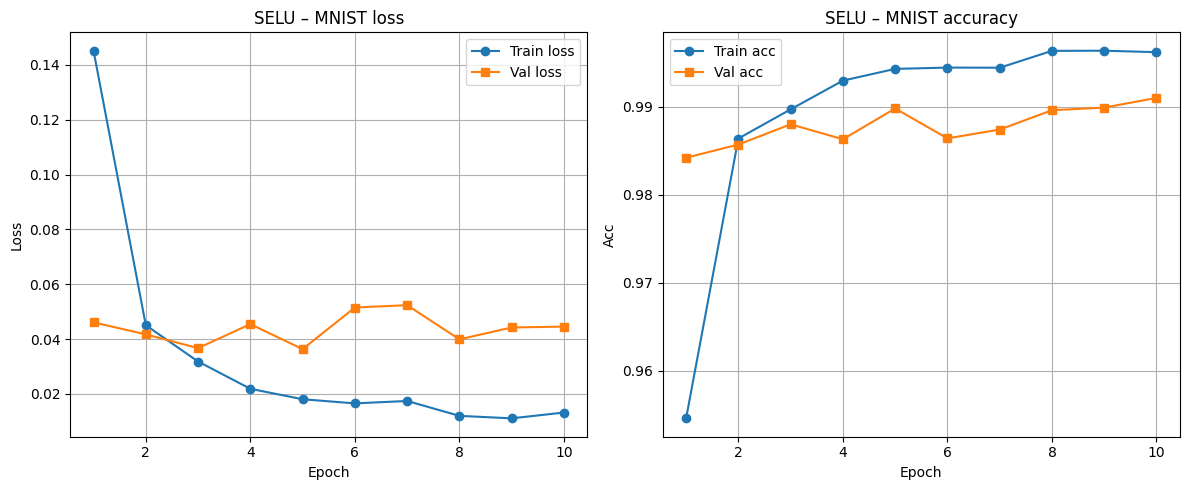

Saved → ./plots/MNIST_selu_curves.png


=== CIFAR-10 EXPERIMENTS ===


--- SIGMOID ---
CIFAR10 [SIGMOID] Epoch 1/10 | TrainLoss 1.9982 ValLoss 1.7147 | TrainAcc 0.2545 ValAcc 0.3632
CIFAR10 [SIGMOID] Epoch 2/10 | TrainLoss 1.5740 ValLoss 1.4542 | TrainAcc 0.4289 ValAcc 0.4674
CIFAR10 [SIGMOID] Epoch 3/10 | TrainLoss 1.4081 ValLoss 1.3660 | TrainAcc 0.4909 ValAcc 0.5016
CIFAR10 [SIGMOID] Epoch 4/10 | TrainLoss 1.3027 ValLoss 1.2537 | TrainAcc 0.5332 ValAcc 0.5486
CIFAR10 [SIGMOID] Epoch 5/10 | TrainLoss 1.2087 ValLoss 1.2104 | TrainAcc 0.5674 ValAcc 0.5649
CIFAR10 [SIGMOID] Epoch 6/10 | TrainLoss 1.1193 ValLoss 1.1375 | TrainAcc 0.5987 ValAcc 0.5940
CIFAR10 [SIGMOID] Epoch 7/10 | TrainLoss 1.0338 ValLoss 1.1021 | TrainAcc 0.6333 ValAcc 0.6063
CIFAR10 [SIGMOID] Epoch 8/10 | TrainLoss 0.9531 ValLoss 1.0534 | TrainAcc 0.6644 ValAcc 0.6259
CIFAR10 [SIGMOID] Epoch 9/10 | TrainLoss 0.8708 ValLoss 1.0393 | TrainAcc 0.6948 ValAcc 0.6303
CIFAR10 [SIGMOID] Epoch 10/10 | TrainLoss 0.7914 ValLoss 0

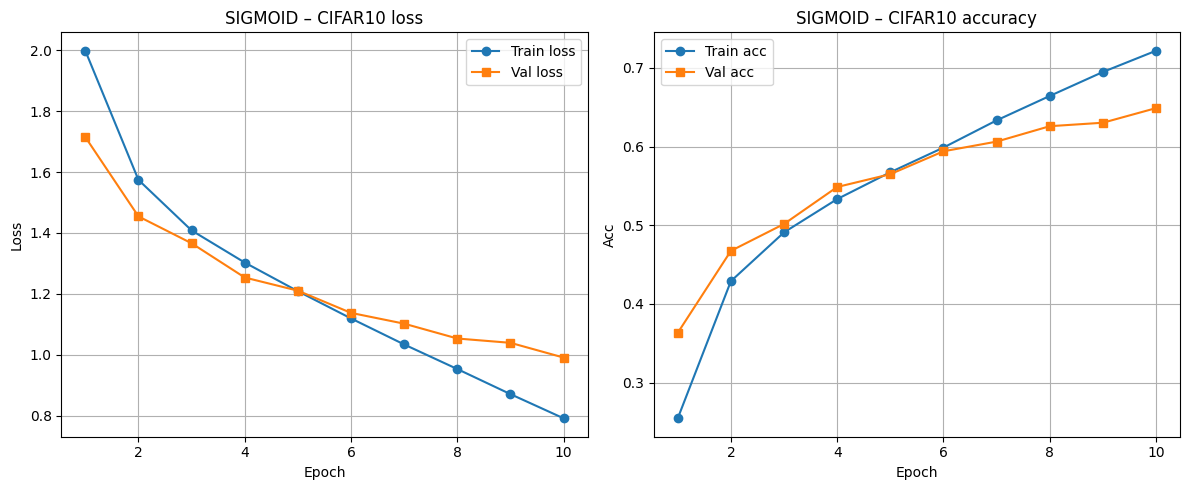

Saved → ./plots/CIFAR10_sigmoid_curves.png


--- TANH ---
CIFAR10 [TANH] Epoch 1/10 | TrainLoss 1.2406 ValLoss 0.9966 | TrainAcc 0.5623 ValAcc 0.6493
CIFAR10 [TANH] Epoch 2/10 | TrainLoss 0.8755 ValLoss 0.9033 | TrainAcc 0.6939 ValAcc 0.6835
CIFAR10 [TANH] Epoch 3/10 | TrainLoss 0.6944 ValLoss 0.8540 | TrainAcc 0.7591 ValAcc 0.7074
CIFAR10 [TANH] Epoch 4/10 | TrainLoss 0.5381 ValLoss 0.7797 | TrainAcc 0.8128 ValAcc 0.7423
CIFAR10 [TANH] Epoch 5/10 | TrainLoss 0.3971 ValLoss 0.8306 | TrainAcc 0.8621 ValAcc 0.7340
CIFAR10 [TANH] Epoch 6/10 | TrainLoss 0.2738 ValLoss 0.8564 | TrainAcc 0.9079 ValAcc 0.7414
CIFAR10 [TANH] Epoch 7/10 | TrainLoss 0.1795 ValLoss 0.9293 | TrainAcc 0.9438 ValAcc 0.7340
CIFAR10 [TANH] Epoch 8/10 | TrainLoss 0.1146 ValLoss 1.0001 | TrainAcc 0.9657 ValAcc 0.7366
CIFAR10 [TANH] Epoch 9/10 | TrainLoss 0.0880 ValLoss 1.0825 | TrainAcc 0.9749 ValAcc 0.7334
CIFAR10 [TANH] Epoch 10/10 | TrainLoss 0.0924 ValLoss 1.1105 | TrainAcc 0.9698 ValAcc 0.7403


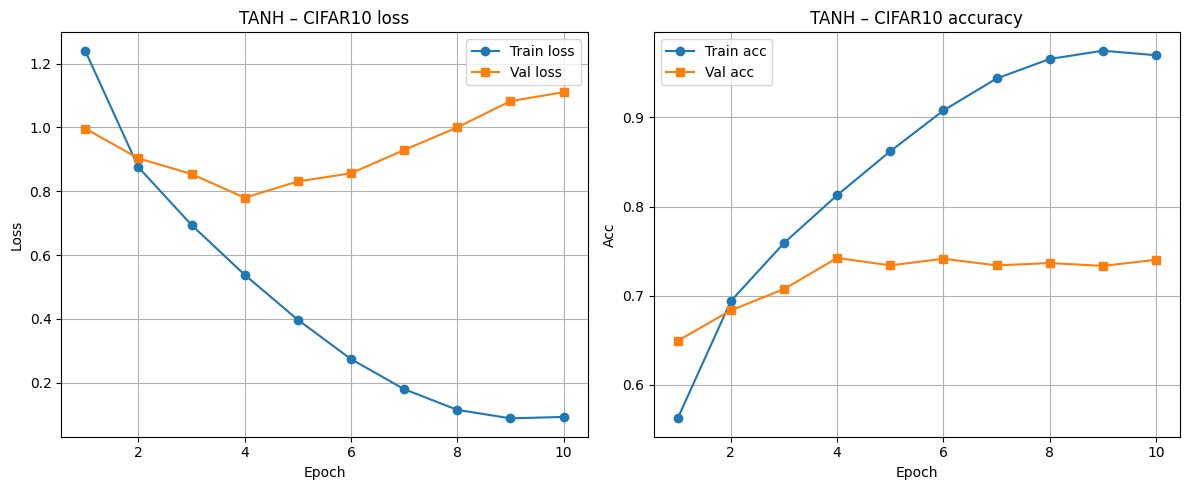

Saved → ./plots/CIFAR10_tanh_curves.png


--- RELU ---
CIFAR10 [RELU] Epoch 1/10 | TrainLoss 1.3560 ValLoss 1.0494 | TrainAcc 0.5104 ValAcc 0.6238
CIFAR10 [RELU] Epoch 2/10 | TrainLoss 0.9159 ValLoss 0.9122 | TrainAcc 0.6760 ValAcc 0.6847
CIFAR10 [RELU] Epoch 3/10 | TrainLoss 0.7233 ValLoss 0.7534 | TrainAcc 0.7459 ValAcc 0.7326
CIFAR10 [RELU] Epoch 4/10 | TrainLoss 0.5890 ValLoss 0.7238 | TrainAcc 0.7919 ValAcc 0.7542
CIFAR10 [RELU] Epoch 5/10 | TrainLoss 0.4803 ValLoss 0.7421 | TrainAcc 0.8332 ValAcc 0.7506
CIFAR10 [RELU] Epoch 6/10 | TrainLoss 0.3764 ValLoss 0.7673 | TrainAcc 0.8694 ValAcc 0.7558
CIFAR10 [RELU] Epoch 7/10 | TrainLoss 0.2815 ValLoss 0.8576 | TrainAcc 0.9013 ValAcc 0.7599
CIFAR10 [RELU] Epoch 8/10 | TrainLoss 0.2095 ValLoss 0.9159 | TrainAcc 0.9260 ValAcc 0.7585
CIFAR10 [RELU] Epoch 9/10 | TrainLoss 0.1483 ValLoss 1.0530 | TrainAcc 0.9486 ValAcc 0.7569
CIFAR10 [RELU] Epoch 10/10 | TrainLoss 0.1226 ValLoss 1.1663 | TrainAcc 0.9564 ValAcc 0.7558


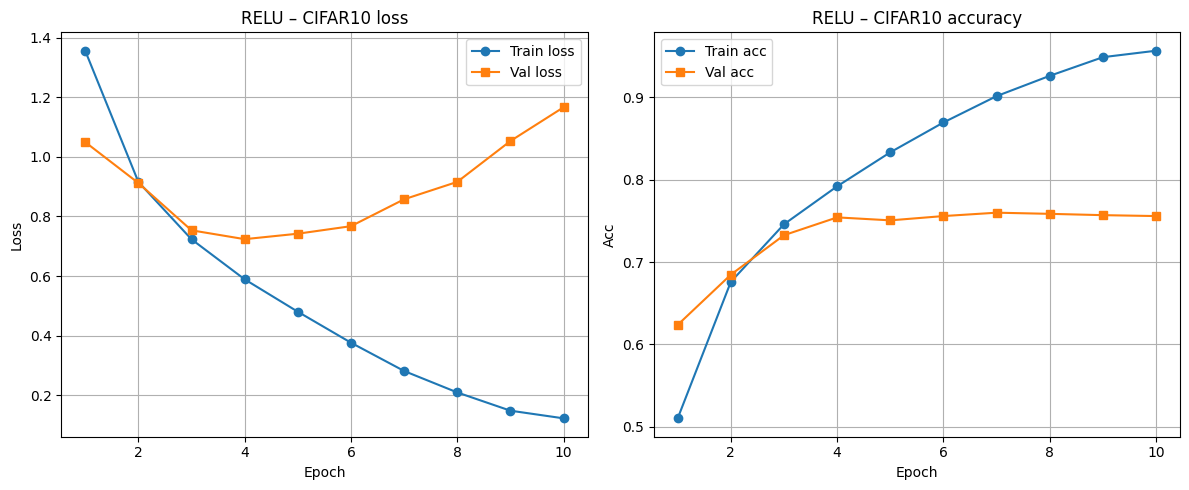

Saved → ./plots/CIFAR10_relu_curves.png


--- ELU ---
CIFAR10 [ELU] Epoch 1/10 | TrainLoss 1.2339 ValLoss 1.0280 | TrainAcc 0.5596 ValAcc 0.6371
CIFAR10 [ELU] Epoch 2/10 | TrainLoss 0.8511 ValLoss 0.9198 | TrainAcc 0.7015 ValAcc 0.6782
CIFAR10 [ELU] Epoch 3/10 | TrainLoss 0.6623 ValLoss 0.7489 | TrainAcc 0.7702 ValAcc 0.7451
CIFAR10 [ELU] Epoch 4/10 | TrainLoss 0.4968 ValLoss 0.7914 | TrainAcc 0.8274 ValAcc 0.7456
CIFAR10 [ELU] Epoch 5/10 | TrainLoss 0.3463 ValLoss 0.8642 | TrainAcc 0.8781 ValAcc 0.7507
CIFAR10 [ELU] Epoch 6/10 | TrainLoss 0.2234 ValLoss 0.9976 | TrainAcc 0.9207 ValAcc 0.7519
CIFAR10 [ELU] Epoch 7/10 | TrainLoss 0.1500 ValLoss 1.0330 | TrainAcc 0.9465 ValAcc 0.7481
CIFAR10 [ELU] Epoch 8/10 | TrainLoss 0.1127 ValLoss 1.2790 | TrainAcc 0.9607 ValAcc 0.7545
CIFAR10 [ELU] Epoch 9/10 | TrainLoss 0.1051 ValLoss 1.3609 | TrainAcc 0.9641 ValAcc 0.7525
CIFAR10 [ELU] Epoch 10/10 | TrainLoss 0.1042 ValLoss 1.5038 | TrainAcc 0.9640 ValAcc 0.7389


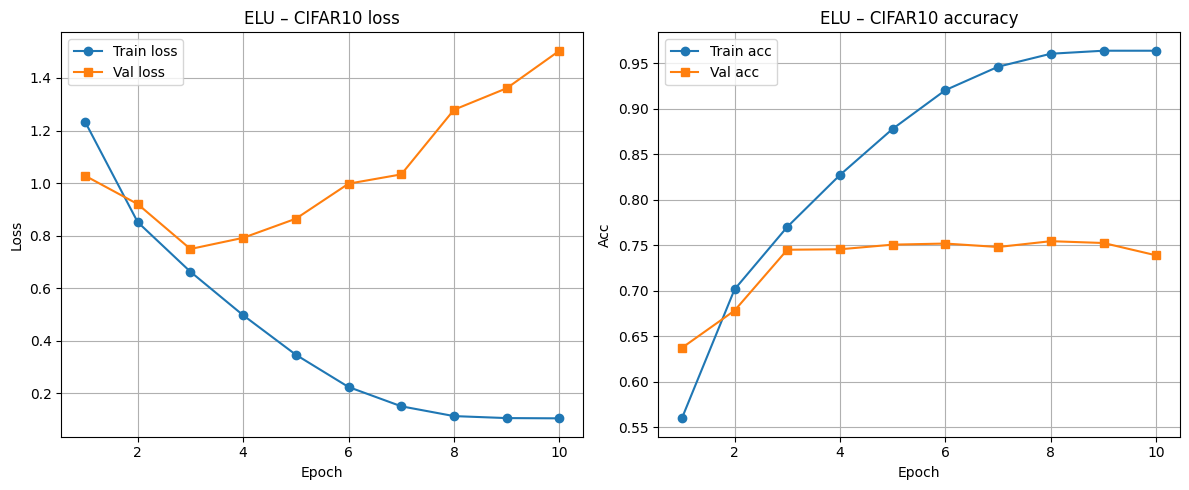

Saved → ./plots/CIFAR10_elu_curves.png


--- SELU ---
CIFAR10 [SELU] Epoch 1/10 | TrainLoss 1.3687 ValLoss 1.0964 | TrainAcc 0.5096 ValAcc 0.6214
CIFAR10 [SELU] Epoch 2/10 | TrainLoss 0.9986 ValLoss 0.9650 | TrainAcc 0.6486 ValAcc 0.6652
CIFAR10 [SELU] Epoch 3/10 | TrainLoss 0.8232 ValLoss 0.8436 | TrainAcc 0.7145 ValAcc 0.7102
CIFAR10 [SELU] Epoch 4/10 | TrainLoss 0.6793 ValLoss 0.8576 | TrainAcc 0.7611 ValAcc 0.7107
CIFAR10 [SELU] Epoch 5/10 | TrainLoss 0.5414 ValLoss 0.8625 | TrainAcc 0.8119 ValAcc 0.7229
CIFAR10 [SELU] Epoch 6/10 | TrainLoss 0.4229 ValLoss 0.9675 | TrainAcc 0.8492 ValAcc 0.7141
CIFAR10 [SELU] Epoch 7/10 | TrainLoss 0.3119 ValLoss 1.0630 | TrainAcc 0.8904 ValAcc 0.7197
CIFAR10 [SELU] Epoch 8/10 | TrainLoss 0.2302 ValLoss 1.2108 | TrainAcc 0.9192 ValAcc 0.7167
CIFAR10 [SELU] Epoch 9/10 | TrainLoss 0.1897 ValLoss 1.3355 | TrainAcc 0.9347 ValAcc 0.7264
CIFAR10 [SELU] Epoch 10/10 | TrainLoss 0.1604 ValLoss 1.4025 | TrainAcc 0.9450 ValAcc 0.7295


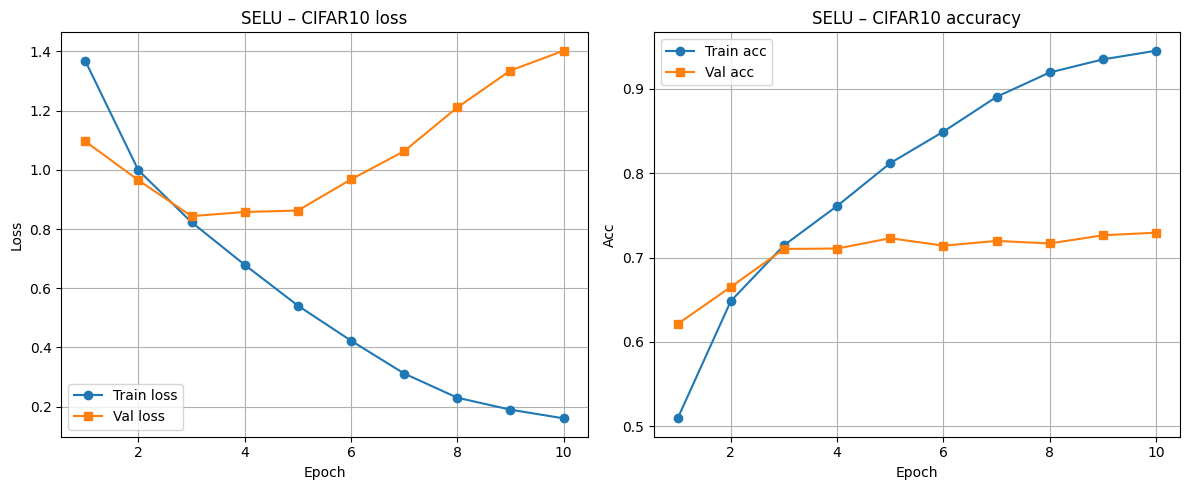

Saved → ./plots/CIFAR10_selu_curves.png


FINAL RESULTS
Best for MNIST   :   RELU  →  Val Acc 0.9911
Best for CIFAR-10:   RELU  →  Val Acc 0.7558


In [ ]:
# results
results_mnist = {}
results_cifar = {}

print("\n=== MNIST EXPERIMENTS ===\n")
for name, act in activations.items():
    print(f"\n--- {name.upper()} ---")
    model = MNIST_CNN(act)
    tl, vl, ta, va = train_model(model,
                                 train_loader_mnist,
                                 val_loader_mnist,
                                 "MNIST", name)
    plot_and_save(name, "MNIST", tl, vl, ta, va)
    results_mnist[name] = va[-1]

print("\n=== CIFAR-10 EXPERIMENTS ===\n")
for name, act in activations.items():
    print(f"\n--- {name.upper()} ---")
    model = CIFAR_CNN(act)
    tl, vl, ta, va = train_model(model,
                                 train_loader_cifar,
                                 val_loader_cifar,
                                 "CIFAR10", name)
    plot_and_save(name, "CIFAR10", tl, vl, ta, va)
    results_cifar[name] = va[-1]

# final verdict
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
best_m = max(results_mnist, key=results_mnist.get)
best_c = max(results_cifar, key=results_cifar.get)
print(f"Best for MNIST   : {best_m.upper():>6}  →  Val Acc {results_mnist[best_m]:.4f}")
print(f"Best for CIFAR-10: {best_c.upper():>6}  →  Val Acc {results_cifar[best_c]:.4f}")